# Demo1: Flight Delay Prediction

In this tutorial, we use the popular [Flights Dataset](http://stat-computing.org/dataexpo/2009/the-data.html) to analyze and predict flight delays in airports based on past flight records. We show how you can use __Jupyter Notebook and Spark__ to read, explore, analyze and visualize your results. 

For this dataset, we will only look at the flights in 2007 - this is still 7 million flights! 

In this notebook, we will build **a classification model to predict airline delay from historical flight data.**  

First, we import some Python packages that we need:

In [1]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import udf
from pyspark.mllib.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.param import Param, Params
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from IPython.display import display
from ipywidgets import interact
import sys
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import os.path
%matplotlib inline

---

### Import data

Here we are using `bash` commands to download the data set for our project.  We can easily do this using Python as well. Bash commands can be exected in DSX notebooks using the `!` operator before the command. After downloading we unzip the file and save it in the file system the notebook is executing in.


In [2]:
my_dir = os.getcwd()

In [3]:
#Will download airline2007.csv if file not yet downloaded

if os.path.isfile("~/resources/airline2007.csv") != True:
    #If file does not already exist, download it, unzip, then delete zipped file
    !wget --quiet --output-document  /gpfs/fs01/user/s12c-e1e4611360e57a-511d20592d9b/notebook/work/airline2007.csv.bz2 http://stat-computing.org/dataexpo/2009/2007.csv.bz2
    !bzip2 -d /gpfs/fs01/user/s12c-e1e4611360e57a-511d20592d9b/notebook/work/airline2007.csv.bz2
    !rm /gpfs/fs01/user/s12c-e1e4611360e57a-511d20592d9b/notebook/work/airline2007.csv.bz2
    print "Downloaded to airline2007.csv"
else:
    #If file already exists
    print "airline2007.csv already exists under /resources/airline2007.csv"
    print "You can continue to the next cell."

bzip2: Output file /gpfs/fs01/user/s12c-e1e4611360e57a-511d20592d9b/notebook/work/airline2007.csv already exists.
Downloaded to airline2007.csv


In [4]:
%ls

airline2007.csv  airports.dat


### Cleaning data
In this section, we remove the header of file

In [5]:
textFile = sc.textFile( 'airline2007.csv')

In [6]:
textFileRDD = textFile.map(lambda x: x.split(','))
header = textFileRDD.first()

textRDD = textFileRDD.filter(lambda r: r != header)

### Creating the Dataframe from RDD
A DataFrame is a distributed collection of data organized into named columns. It is conceptually equivalent to a table in a relational database or a data frame in Python, but with richer optimizations under the hood.

In [7]:
def parse(r):
    try:
        x=Row(Year=int(r[0]),\
          Month=int(r[1]),\
          DayofMonth=int(r[2]),\
          DayOfWeek=int(r[3]),\
          DepTime=int(float(r[4])), \
          CRSDepTime=int(r[5]),\
          ArrTime=int(float(r[6])),\
          CRSArrTime=int(r[7]), \
          UniqueCarrier=r[8],\
          DepDelay=int(float(r[15])),\
          Origin=r[16],\
          Dest=r[17], \
          Distance=int(float(r[18])))  
    except:
        x=None  
    return x

rowRDD = textRDD.map(lambda r: parse(r)).filter(lambda r:r != None)
airline_df = sqlContext.createDataFrame(rowRDD)

In this section, we add a new column to our data frame, **DepDelayed**, a binary variable:
- **True**, for flights that have > 15 minutes of delay
- **False**, for flights that have <= 15 minutes of delay

We will later use **Depdelayed** as the target/label column in the classification process.

In [8]:
airline_df = airline_df.withColumn('DepDelayed', airline_df['DepDelay']>15)

We also add a new column, __Hour__, to determine the hour of flight (0 to 24).

In [9]:
# define hour function to obtain hour of day
def hour_ex(x): 
    h = int(str(int(x)).zfill(4)[:2])
    return h

# register as a UDF 
f = udf(hour_ex, IntegerType())

#CRSDepTime: scheduled departure time (local, hhmm)
airline_df = airline_df.withColumn('hour', f(airline_df.CRSDepTime))
airline_df.registerTempTable("airlineDF")

## Exploration
Let's do some exploration of this dataset.  
### Exploration: Which Airports have the Most Delays?

---
#### Spark DataFrames vs. Pandas:

>    Spark DataFrames are distributed in the Spark cluster and Pandas dataframes are in memory in the driver node.  Pandas dataframes are more flexible to work with but should be used on sampled or aggregated data if your original data set is very large.  The most popular way to use Spark DataFrames is to load into the cluster then write SQL against using SparkSQL.

In [10]:

query = '''
SELECT Origin, count(*) conFlight,avg(DepDelay) delay
FROM airlineDF 
GROUP BY Origin
ORDER BY delay DESC'''

groupedDelay = sqlContext.sql(query)

df_origin = groupedDelay.toPandas()
df_origin.head()

,Origin,conFlight,delay
0,ACK,277,51.346570
1,PIR,4,45.500000
2,SOP,185,35.859459
3,HHH,944,23.855932
4,MCN,936,23.842949


__Notice:__ To map each Airport to corresponding _Long_ and _Lat_, run the following cell to download the needed dataset.

## Enrich our data set

The origin airport codes are helpful but they do not give us any real location information.  Here we grab another data set that has the IATA airport codes as well as other location data.  After downloading we will merge with the grouped dataframe from the previous cell.

In [11]:
# Will download airports.dat if not found in /resources/

if os.path.isfile("airports1.dat") != True:
    #If file does not already exist, download it
    !wget  --quiet --output-document airports.dat \
        https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
    print "Downloaded to airports.dat"
else:
    #If file already exists
    print "airports.dat already exists under airports.dat"
    print "You can continue to the next cell."

Downloaded to airports.dat


In [12]:
df = pd.read_csv('airports.dat', index_col=0,\
names = ['name', 'city', 'country','IATA','ICAO','lat','lng','alt','TZone','DST','Tz', 'c12', 'c13'], \
            header=0)

In [13]:
df_airports = pd.merge(df_origin, df, left_on = 'Origin', right_on = 'IATA')


In [14]:
df_airports.head()

,Origin,conFlight,delay,name,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz,c12,c13
0,ACK,277,51.346570,Nantucket Memorial Airport,Nantucket,United States,ACK,KACK,41.253101,-70.060204,47,-5,A,America/New_York,airport,OurAirports
1,PIR,4,45.500000,Pierre Regional Airport,Pierre,United States,PIR,KPIR,44.382702,-100.286003,1744,-6,A,America/Chicago,airport,OurAirports
2,SOP,185,35.859459,Moore County Airport,Pinehurst-Southern Pines,United States,SOP,KSOP,35.237400,-79.391197,455,-5,A,America/New_York,airport,OurAirports
3,HHH,944,23.855932,Hilton Head Airport,Hilton Head Island,United States,HHH,KHXD,32.224400,-80.697502,19,-5,A,America/New_York,airport,OurAirports
4,MCN,936,23.842949,Middle Georgia Regional Airport,Macon,United States,MCN,KMCN,32.692799,-83.649200,354,-5,A,America/New_York,airport,OurAirports


In [15]:
#Helper functions for our visualizations
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def zscore(x):
    return (x-np.average(x))/np.std(x)

Plot the map:

Each marker is an airport.
Size of markers: Airport Traffic (larger means higher number of flights in year)
Color of markers: Average Flight Delay (Redder means longer delays)


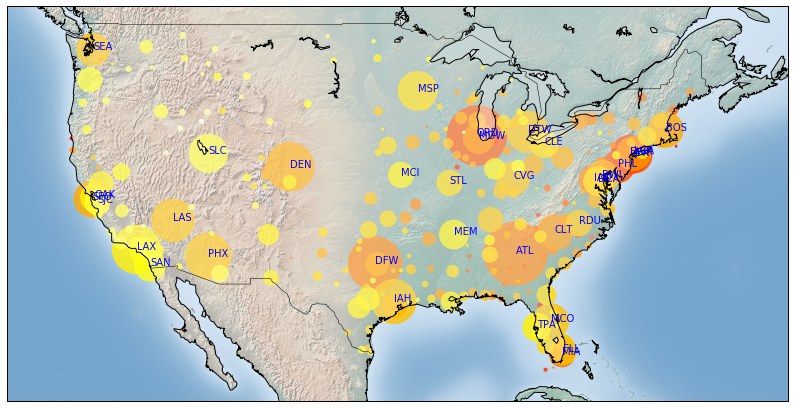

In [16]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = (14,10)


my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=-60, urcrnrlat=50) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('hot')(np.linspace(0.0, 1.0, 30))
colors=np.flipud(colors)

#----- Scatter -------
countrange=max(df_airports['conFlight'])-min(df_airports['conFlight'])
al=np.array([sigmoid(x) for x in zscore(df_airports['delay'])])
xs,ys = my_map(np.asarray(df_airports['lng']), np.asarray(df_airports['lat']))
val=df_airports['conFlight']*4000.0/countrange

my_map.scatter(xs, ys,  marker='o', s= val, alpha = 0.8,color=colors[(al*20).astype(int)])

#----- Text -------
df_text=df_airports[(df_airports['conFlight']>60000) & (df_airports['IATA'] != 'HNL')]
xt,yt = my_map(np.asarray(df_text['lng']), np.asarray(df_text['lat']))
txt=np.asarray(df_text['IATA'])
zp=zip(xt,yt,txt)
for row in zp:
    #print zp[2]
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each marker is an airport.")
print("Size of markers: Airport Traffic (larger means higher number of flights in year)")
print("Color of markers: Average Flight Delay (Redder means longer delays)")

plt.show()

### Exploration: Route delay

#### Which Routes are typically the most delayed?

In [17]:
grp_rout_Delay = sqlContext.sql("SELECT Origin, Dest, count(*) traffic,avg(Distance) avgDist,\
                                    avg(DepDelay) avgDelay\
                                FROM airlineDF \
                                GROUP BY Origin,Dest")
rout_Delay = grp_rout_Delay.toPandas()
rout_Delay.head()

,Origin,Dest,traffic,avgDist,avgDelay
0,ATL,CVG,2707,373.0,12.442556
1,ATL,SJC,733,2116.0,10.645293
2,MOB,ATL,2095,302.0,17.823389
3,BTR,ATL,2311,449.0,24.244916
4,ATL,ERI,441,626.0,23.657596


In [18]:
df_airport_rout1 = pd.merge(rout_Delay, df, left_on = 'Origin', right_on = 'IATA')
df_airport_rout2 = pd.merge(df_airport_rout1, df, left_on = 'Dest', right_on = 'IATA')
df_airport_rout = df_airport_rout2[["Origin","lat_x","lng_x","Dest","lat_y","lng_y",\
                                    "avgDelay", "traffic"]]
df_airport_rout.head()

,Origin,lat_x,lng_x,Dest,lat_y,lng_y,avgDelay,traffic
0,ATL,33.636700,-84.428101,CVG,39.048801,-84.667801,12.442556,2707
1,BTR,30.533199,-91.149597,CVG,39.048801,-84.667801,12.955182,357
2,DAY,39.902401,-84.219398,CVG,39.048801,-84.667801,4.782853,1248
3,BOS,42.364300,-71.005203,CVG,39.048801,-84.667801,8.208544,1779
4,DCA,38.852100,-77.037697,CVG,39.048801,-84.667801,4.184932,1606


Each line represents a route from the Origin to Destination airport.
The redder line, the higher probablity of delay.


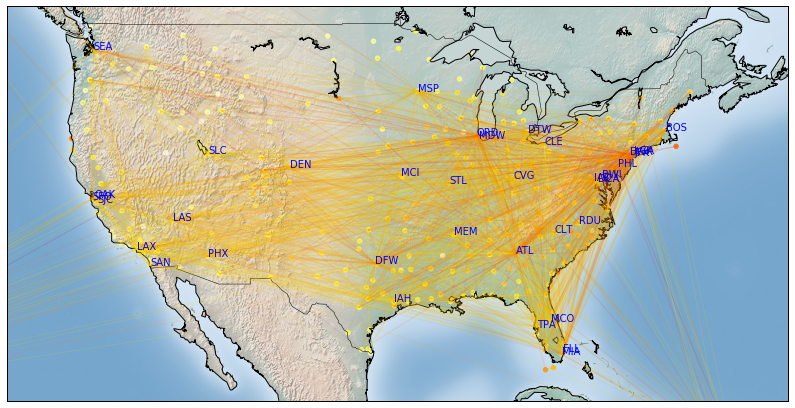

In [19]:


rcParams['figure.figsize'] = (14,10)


my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=-60, urcrnrlat=50) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

delay=np.array([sigmoid(x) for x in zscore(df_airports["delay"])])
colors = plt.get_cmap('hot')(np.linspace(0.0, 1.0, 40))
colors=np.flipud(colors)
xs,ys = my_map(np.asarray(df_airports['lng']), np.asarray(df_airports['lat']))
xo,yo = my_map(np.asarray(df_airport_rout['lng_x']), np.asarray(df_airport_rout['lat_x']))
xd,yd = my_map(np.asarray(df_airport_rout['lng_y']), np.asarray(df_airport_rout['lat_y']))

my_map.scatter(xs, ys,  marker='o',  alpha = 0.8,color=colors[(delay*20).astype(int)])


al=np.array([sigmoid(x) for x in zscore(df_airport_rout["avgDelay"])])
f=zip(xo,yo,xd,yd,df_airport_rout['avgDelay'],al)
for row in f:
    plt.plot([row[0],row[2]], [row[1],row[3]],'-',alpha=0.07, \
             color=colors[(row[5]*30).astype(int)] )
    

for row in zp:
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each line represents a route from the Origin to Destination airport.")
print("The redder line, the higher probablity of delay.")
    
plt.show()



---

# Challenge - Draw a map only showing connections with your local airport

---

### Exploration: Airport Origin delay per month

Set the airport code name below to explore

In [20]:
Origin_Airport="JFK"

In [26]:
df_ORG = sqlContext.sql("SELECT * from airlineDF WHERE origin='"+ Origin_Airport+"'")
df_ORG.registerTempTable("df_ORG")
df_ORG.select('ArrTime','CRSArrTime','CRSDepTime',\
              'DayOfWeek','DayofMonth','DepDelay','DepTime','Dest', 'UniqueCarrier').show(2)

+-------+----------+----------+---------+----------+--------+-------+----+-------------+
|ArrTime|CRSArrTime|CRSDepTime|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|UniqueCarrier|
+-------+----------+----------+---------+----------+--------+-------+----+-------------+
|   1608|      1621|      1435|        6|        13|     -19|   1416| CLE|           XE|
|   2223|      1955|      1750|        1|         1|     165|   2035| CLE|           XE|
+-------+----------+----------+---------+----------+--------+-------+----+-------------+
only showing top 2 rows



Let's look at flights originating from this airport:

In [27]:
print "total flights from this ariport: " + str(df_ORG.count())

total flights from this ariport: 122035


In this section, we group flights by month to see how delayed flights are distributed by month:

In [33]:
from pixiedust import display


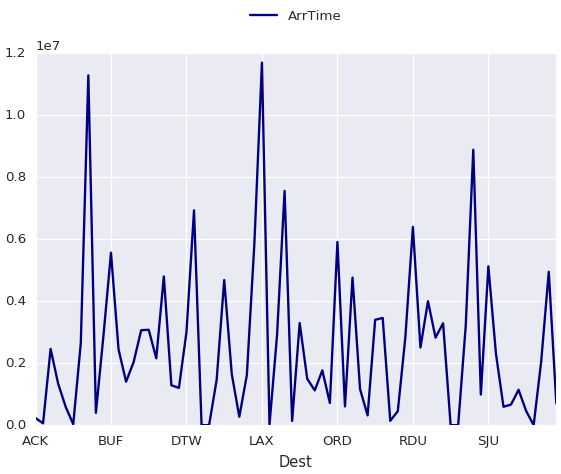

In [64]:
display(df_ORG)

In [28]:
grp_carr = sqlContext.sql("SELECT  UniqueCarrier,month, avg(DepDelay) avgDelay from df_ORG \
                            WHERE DepDelayed=True \
                            GROUP BY UniqueCarrier,month")
s = grp_carr.toPandas()
s.head()

,UniqueCarrier,month,avgDelay
0,DL,1,56.248062
1,DL,2,72.287625
2,DL,3,54.483376
3,DL,4,63.986702
4,DL,5,48.972752


In [29]:
ps = s.pivot(index='month', columns='UniqueCarrier', values='avgDelay')[['AA','UA','US']]
ps

UniqueCarrier,AA,UA,US
month,,,
1,60.995074,58.166667,52.000000
2,75.000000,71.509434,67.431034
3,60.346154,57.717391,61.106061
4,65.216495,63.981818,70.872340
5,66.708738,71.571429,59.020833
6,64.019531,88.039474,99.120000
7,72.788591,67.174603,65.591837
8,74.574830,83.794872,80.851064
9,67.643192,56.215686,44.435897


In [35]:
def conditional_format(row, max_val, min_val):
    interval = (max_val - min_val) / 3
    style_row = []
    for val in row:
        if val < min_val + interval:
            x = "background: #a0ffad"
        elif val > min_val + (interval * 2) :
            x = "background: #ff6d6d"
        else:
            x = "background: #fff587"
        style_row.append(x)
    return(style_row)

In [36]:
my_max = ps.values.max()
my_min = ps.values.min()
ps.style.apply(lambda x: conditional_format(x,my_max ,my_min), axis = 1)

UniqueCarrier,AA,UA,US
month,,,
1,60.9951,58.1667,52
2,75,71.5094,67.431
3,60.3462,57.7174,61.1061
4,65.2165,63.9818,70.8723
5,66.7087,71.5714,59.0208
6,64.0195,88.0395,99.12
7,72.7886,67.1746,65.5918
8,74.5748,83.7949,80.8511
9,67.6432,56.2157,44.4359


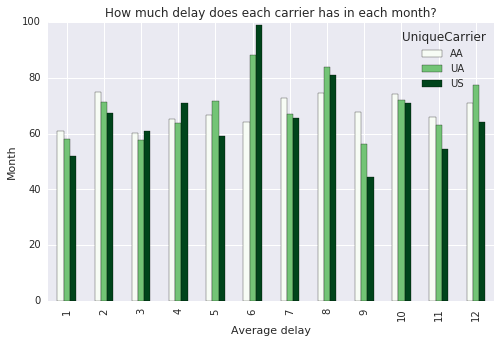

In [37]:
rcParams['figure.figsize'] = (8,5)
ps.plot(kind='bar', colormap='Greens');
plt.xlabel('Month')
plt.ylabel('Average delay')
plt.title('How much delay does each carrier has in each month?')

We see that average delay in this year is is highest in June and August in this airport.

### Exploration: Airport Origin delay per day/hour

In [47]:
hour_grouped = df_ORG.filter(df_ORG['DepDelayed']).select('DayOfWeek','hour','DepDelay').groupby('DayOfWeek','hour').mean('DepDelay')


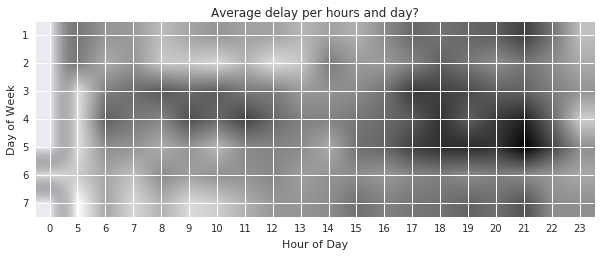

In [48]:
rcParams['figure.figsize'] = (10,5)
dh = hour_grouped.toPandas()
c = dh.pivot('DayOfWeek','hour')
X = c.columns.levels[1].values
Y = c.index.values
Z = c.values
plt.xticks(range(0,24), X)
plt.yticks(range(0,7), Y)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.title('Average delay per hours and day?')
plt.imshow(Z)

A clear pattern here: flights tend to be delayed in these situations:  
- Later in the day: possibly because delays tend to pile up as the day progresses and the problem tends to compound later in the day.  
- Mornings in first day of week possibly because of more business meetings

## Modeling: Logistic Regression
In this section, we will build a supervised learning model to predict flight delays for flights leaving our selected airport.


### Preprocessing: Feature selection
In the next two cell we select the features that we need to create the model.

In [49]:
df_model=df_ORG
# stringIndexer1 = StringIndexer(inputCol="Origin", outputCol="originIndex")
# model_stringIndexer = stringIndexer1.fit(df_model)
# indexedOrigin = model_stringIndexer.transform(df_model)
# encoder1 = OneHotEncoder(dropLast=False, inputCol="originIndex", outputCol="originVec")
# df_model = encoder1.transform(indexedOrigin)

In [50]:
stringIndexer2 = StringIndexer(inputCol="Dest", outputCol="destIndex")
model_stringIndexer = stringIndexer2.fit(df_model)
indexedDest = model_stringIndexer.transform(df_model)
encoder2 = OneHotEncoder(dropLast=False, inputCol="destIndex", outputCol="destVec")
df_model = encoder2.transform(indexedDest)

We use __labeled point__ to make local vectors associated with a label/response. In MLlib, labeled points are used in supervised learning algorithms and they are stored as doubles. For binary classification, a label should be either 0 (negative) or 1 (positive). 

In [51]:
assembler = VectorAssembler(
    inputCols = ['Year','Month','DayofMonth','DayOfWeek','hour','Distance','destVec'],
    outputCol = "features")
output = assembler.transform(df_model)
airlineRDD=output.map(lambda row: LabeledPoint([0,1][row['DepDelayed']],row['features']))

### Preprocessing: Spliting dataset into train and test dtasets

In [52]:
trainRDD,testRDD=airlineRDD.randomSplit([0.7,0.3])
#print str(trainRDD.count()) +"  "+ str(testRDD.count())

In [58]:
testRDD.take(1)

[LabeledPoint(0.0, (76,[0,1,2,3,4,5,43],[2007.0,1.0,2.0,2.0,17.0,425.0,1.0]))]

### Build the model

In [63]:
model = LogisticRegressionWithLBFGS.train(trainRDD)

## Model Evaluation

In [60]:
# Evaluating the model on testing data
labelsAndPreds = testRDD.map(lambda p: (p.label, model.predict(p.features)))
labelsAndPreds.take(5)

[(0.0, 1), (1.0, 0), (1.0, 0), (1.0, 0), (1.0, 0)]

In [61]:
def conf(r):
    if r[0] == r[1] ==1: x= 'TP'
    if r[0] == r[1] ==0: x= 'TN'
    if r[0] == 1 and  r[1] ==0: x= 'FN'
    if r[0] == 0 and  r[1] ==1: x= 'FP'
    return (x)
acc1 = labelsAndPreds.map(lambda (v, p): ((v, p),1)).reduceByKey(lambda a, b: a + b).take(5)
acc = [(conf(x[0]),x[1]) for x in acc1]

In [62]:
TP=TN=FP=FN=0.0
for x in acc: 
    if x[0]=='TP': TP= x[1]
    if x[0]=='TN': TN= x[1]
    if x[0]=='FP': FP= x[1]
    if x[0]=='FN': FN= x[1]
eps = sys.float_info.epsilon
Accuracy = (TP+TN) / (TP + TN+ FP+FN+eps) 
print "Model Accuracy for JFK: %1.2f %%" % (Accuracy*100)

Model Accuracy for JFK: 73.00 %


### Next steps - deploy the model using Watson Machine Learning